In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm
import time

In [20]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [22]:
# Hyperparameters
batch_size = 50
num_classes = 101
learning_rate = 1e-4
num_epochs = 5
temperature = 4.0  # For distillation
alpha = 0.7  # Balance between distillation loss and standard loss

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load Food-101 dataset
train_dataset = datasets.Food101(root="data", split="train", transform=transform, download=True)
test_dataset = datasets.Food101(root="data", split="test", transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
# Load Pre-trained Teacher Model from Local File
teacher_model = timm.create_model("resnetv2_50x1_bitm", pretrained=False, num_classes=num_classes)
teacher_model.load_state_dict(torch.load("teacher models/bitm_resnet50x1_F101.pth", map_location=device))
teacher_model.to(device)
teacher_model.eval()

print("Teacher model loaded successfully!")

/tmp/ipykernel_1025/1839668212.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("bitm_resnet50x1_F101.pth", map_location=device))

Teacher model loaded successfully!


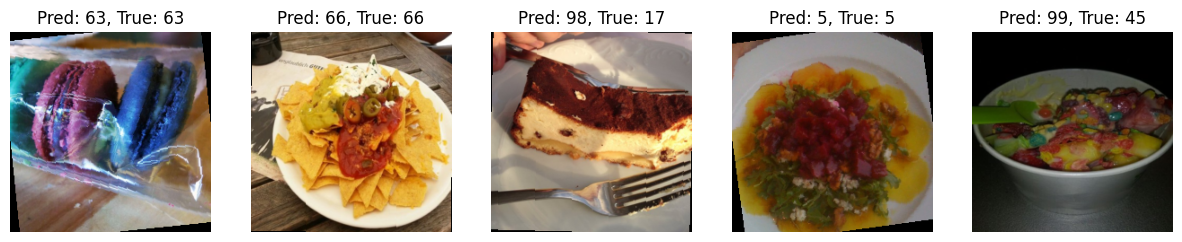

In [24]:
import random
import matplotlib.pyplot as plt

# Function to visualize predictions on 5 random samples
def predict_and_visualize(model, dataset, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    # Select 5 random indices from the dataset
    indices = random.sample(range(len(dataset)), num_samples)
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension
        
        # Perform inference
        with torch.no_grad():
            output = model(image_tensor)
            predicted_class = torch.argmax(output, dim=1).item()

        # Convert tensor image back to numpy for visualization
        image = image.permute(1, 2, 0).cpu().numpy()
        image = (image * 0.5) + 0.5  # Unnormalize

        # Display the image with prediction
        axes[i].imshow(image)
        axes[i].set_title(f"Pred: {predicted_class}, True: {label}")
        axes[i].axis("off")

    plt.show()

# Test 5 random samples from the Food-101 test dataset
predict_and_visualize(teacher_model, test_dataset)

In [25]:
# Define Student Model (MobileNetV3 Small)
student_model = timm.create_model("efficientnet_b3", pretrained=True, num_classes=num_classes).to(device)

In [26]:
# Loss Functions and Optimizers
criterion = nn.CrossEntropyLoss()
distillation_criterion = nn.KLDivLoss(reduction="batchmean")
optimizer = optim.AdamW(student_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_1025/2569195992.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [33]:
def train_student():
    student_model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        
        for batch_idx, (images, labels) in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with torch.no_grad():
                teacher_outputs = teacher_model(images)

            with torch.autocast(device_type="cuda", dtype=torch.float16):
                student_outputs = student_model(images)
                loss_hard = criterion(student_outputs, labels)
                loss_soft = distillation_criterion(
                    F.log_softmax(student_outputs / temperature, dim=1),
                    F.softmax(teacher_outputs / temperature, dim=1)
                )
                loss = alpha * loss_soft + (1 - alpha) * loss_hard
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = student_outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item(), acc=100*correct/total)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()

In [34]:
def evaluate_model():
    student_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = student_model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    print(f"EfficientNet-B3 Student Model - Test Accuracy: {acc:.2f}%")
    return acc

In [35]:
# Function to measure model performance
def measure_model_performance(model, model_name):
    model.eval()
    num_params = sum(p.numel() for p in model.parameters())
    print(f"{model_name} - Number of Parameters: {num_params:,}")
    
    start_time = time.time()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            _ = model(images)
            break  # Measure for a single batch
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"{model_name} - Inference Time (1 batch): {inference_time:.4f} seconds")

In [36]:
import gc
torch.cuda.empty_cache()
gc.collect()

57115

In [37]:
train_student()

Epoch [1/5], Loss: 0.7617, Accuracy: 55.26%


Epoch [2/5], Loss: 0.3401, Accuracy: 77.93%


Epoch [3/5], Loss: 0.2404, Accuracy: 84.72%


Epoch [4/5], Loss: 0.1795, Accuracy: 89.67%


Epoch [5/5], Loss: 0.1380, Accuracy: 93.28%


In [38]:
evaluate_model()

EfficientNet-B3 Student Model - Test Accuracy: 84.11%


84.1069306930693

In [39]:
# Measure Performance
measure_model_performance(teacher_model, "Teacher Model (ResNetv2-50x1-BiT)")
measure_model_performance(student_model, "Student Model (EfficientNet-B3)")

Teacher Model (ResNetv2-50x1-BiT) - Number of Parameters: 23,707,301
Teacher Model (ResNetv2-50x1-BiT) - Inference Time (1 batch): 0.9111 seconds
Student Model (EfficientNet-B3) - Number of Parameters: 10,851,469
Student Model (EfficientNet-B3) - Inference Time (1 batch): 0.9037 seconds


In [40]:
# Save Model
torch.save(student_model.state_dict(), "efficientnet_b3_student_f101.pth")
print("EfficientNet-B3 Student Model saved successfully!")

EfficientNet-B3 Student Model saved successfully!


In [41]:
# Define Student Models
efficientnet_b0 = timm.create_model("efficientnet_b0", pretrained=True, num_classes=num_classes).to(device)
mobilenet_large = models.mobilenet_v3_large(num_classes=num_classes).to(device)

In [42]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
distillation_criterion = nn.KLDivLoss(reduction="batchmean")

optimizer_effnet = optim.AdamW(efficientnet_b0.parameters(), lr=learning_rate, weight_decay=1e-4)
optimizer_mobilenet = optim.AdamW(mobilenet_large.parameters(), lr=learning_rate, weight_decay=1e-4)

In [43]:
# Training Function
def train_student(student_model, optimizer, model_name):
    student_model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        
        for batch_idx, (images, labels) in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with torch.no_grad():
                teacher_outputs = teacher_model(images)
            
            student_outputs = student_model(images)
            loss_hard = criterion(student_outputs, labels)
            loss_soft = distillation_criterion(
                F.log_softmax(student_outputs / temperature, dim=1),
                F.softmax(teacher_outputs / temperature, dim=1)
            )
            loss = alpha * loss_soft + (1 - alpha) * loss_hard
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = student_outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item(), acc=100 * correct / total)
        
        print(f"{model_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")
        
        # Free up memory
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

In [44]:
# Evaluation Function
def evaluate_model(student_model, model_name):
    student_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = student_model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    print(f"{model_name} - Test Accuracy: {acc:.2f}%")
    return acc

In [45]:
# Train both models
train_student(efficientnet_b0, optimizer_effnet, "EfficientNet-B0")
acc_effnet = evaluate_model(efficientnet_b0, "EfficientNet-B0")

EfficientNet-B0 - Epoch [1/5], Loss: 0.7966, Accuracy: 53.65%


EfficientNet-B0 - Epoch [2/5], Loss: 0.3912, Accuracy: 74.58%


EfficientNet-B0 - Epoch [3/5], Loss: 0.2951, Accuracy: 80.85%


EfficientNet-B0 - Epoch [4/5], Loss: 0.2356, Accuracy: 85.38%


EfficientNet-B0 - Epoch [5/5], Loss: 0.1933, Accuracy: 88.66%
EfficientNet-B0 - Test Accuracy: 82.86%


In [46]:
train_student(mobilenet_large, optimizer_mobilenet, "MobileNetV3-Large")
acc_mobilenet = evaluate_model(mobilenet_large, "MobileNetV3-Large")

MobileNetV3-Large - Epoch [1/5], Loss: 1.7082, Accuracy: 6.91%


MobileNetV3-Large - Epoch [2/5], Loss: 1.5167, Accuracy: 13.84%


MobileNetV3-Large - Epoch [3/5], Loss: 1.3939, Accuracy: 19.30%


MobileNetV3-Large - Epoch [4/5], Loss: 1.2870, Accuracy: 24.18%


MobileNetV3-Large - Epoch [5/5], Loss: 1.1987, Accuracy: 28.23%
MobileNetV3-Large - Test Accuracy: 31.90%


In [47]:
# Save the best model
if acc_effnet > acc_mobilenet:
    torch.save(efficientnet_b0.state_dict(), "student models/best_student_B0_f101.pth")
    print("EfficientNet-B0 is the best student model and has been saved.")
else:
    torch.save(mobilenet_large.state_dict(), "student models/best_student_V3_model.pth")
    print("MobileNetV3-Large is the best student model and has been saved.")

EfficientNet-B0 is the best student model and has been saved.


In [48]:
measure_model_performance(teacher_model, "Teacher Model (ResNetv2-50x1-BiT)")
measure_model_performance(efficientnet_b0, "Student Model (efficientnet_b0)")
measure_model_performance(mobilenet_large, "Student Model (mobilenet_large)")

Teacher Model (ResNetv2-50x1-BiT) - Number of Parameters: 23,707,301
Teacher Model (ResNetv2-50x1-BiT) - Inference Time (1 batch): 0.9224 seconds
Student Model (efficientnet_b0) - Number of Parameters: 4,136,929
Student Model (efficientnet_b0) - Inference Time (1 batch): 0.9168 seconds
Student Model (mobilenet_large) - Number of Parameters: 4,331,413
Student Model (mobilenet_large) - Inference Time (1 batch): 0.9333 seconds
